#  **AI-Tutor** **AI** **Driven** **Topic**  **Modeling**


### **Problem statement**
-  There is no mechanism to understand the engagement level of the student watching the learning videos. At what
topics they are getting disengaged is not captured. Hence, we are unable to provide personalized feedback on
which topics they are not good at.


### Import Required Packages

In [1]:
!pip install pydub
!pip install pytube
!pip install SpeechRecognition
!pip install openai
!pip install assemblyai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00


### **1.** **Extracting** **Audio** **from** **Youtube**

In [20]:
import os
from pytube import YouTube
from moviepy.editor import *

import os
import speech_recognition as sr
from pydub import AudioSegment
from pydub.silence import split_on_silence


def extract_audio_from_youtube(video_url, output_path):
    try:
        # Download the YouTube video
        yt = YouTube(video_url)
        video_stream = yt.streams.filter(only_audio=True).first()
        video_stream.download(output_path)

        # Extract audio from the downloaded video
        video_path = os.path.join(output_path, video_stream.default_filename)
        audio_clip = AudioFileClip(video_path)
        audio_clip.write_audiofile(output_path + "/youtube_wav.wav", codec="pcm_s16le")
        audio_clip.close()

        # Remove the downloaded video
        os.remove(video_path)
        print("Audio extracted successfully and saved as youtube_wav.wav")
    except Exception as e:
        print("Error:", str(e))

if __name__ == "__main__":
    video_url = "https://youtu.be/-5tNYkN2p7c?si=sQkYXC4dH4yd3_0N"
    output_folder = "OUTPUT"

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    extract_audio_from_youtube(video_url, output_folder)


MoviePy - Writing audio in OUTPUT/youtube_wav.wav


MoviePy - Done.
Audio extracted successfully and saved as youtube_wav.wav


### **2.** **Extracting** **Text** **from** **Audio** **with** **Timestamp**

In [22]:
import assemblyai as aai
import datetime

aai.settings.api_key = "your key here"
transcriber = aai.Transcriber()

audio_path = "/content/OUTPUT/youtube_wav.wav"
transcript = transcriber.transcribe(audio_path)

previous_end_time = None
sentence = []
output_text = ""  # Collect the text to be written to the file

for word in transcript.words:
    start_time = word.start
    end_time = word.end
    word_text = word.text

    if previous_end_time is None:
        sentence.append(word_text)
    else:
        time_diff = datetime.timedelta(seconds=start_time - previous_end_time)
        if time_diff.total_seconds() >= 2:
            sentence.append(word_text)

        if len(sentence) >= 6:
            output_text += f"{previous_end_time:.2f}  : {' '.join(sentence)}\n"
            sentence = []

    previous_end_time = end_time

if sentence:
    output_text += f"{previous_end_time:.2f}  : {' '.join(sentence)}\n"

# Save the output to a text file
output_file_path = "/content/OUTPUT/transcription_output.txt"
with open(output_file_path, "w") as output_file:
    output_file.write(output_text)

print("Transcription saved to:", output_file_path)


Transcription saved to: /content/OUTPUT/transcription_output.txt


In [23]:

# Convert milliseconds to hours:minutes:seconds format (without milliseconds) and save to another text file
time_conversion_output = ""
with open(output_file_path, "r") as input_file:
    for line in input_file:
        parts = line.strip().split("  : ")
        milliseconds = float(parts[0])
        hours, milliseconds = divmod(milliseconds, 3600000)
        minutes, milliseconds = divmod(milliseconds, 60000)
        seconds = int(milliseconds / 1000)
        time_string = f"{int(hours):02}:{int(minutes):02}:{seconds:02}"
        time_conversion_output += f"{time_string}  : {parts[1]}\n"

time_output_file_path = "/content/OUTPUT/time_conversion_output.txt"
with open(time_output_file_path, "w") as time_output_file:
    time_output_file.write(time_conversion_output)

print("Time conversion saved to:", time_output_file_path)



Time conversion saved to: /content/OUTPUT/time_conversion_output.txt


### **3.** **Text** **Preprocessing**

In [25]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Define preprocessing functions
def remove_special_characters(text):
    pattern = r'[^a-zA-Z\s]'  # Remove anything that is not a letter or whitespace
    return re.sub(pattern, '', text)

def lowercase_text(text):
    return text.lower()

def remove_stopwords(text, custom_stopwords=None):
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_text)

def perform_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_text)

def preprocess_text(text, custom_stopwords=None):
    text = remove_special_characters(text)
    text = lowercase_text(text)
    text = remove_stopwords(text, custom_stopwords)
    text = perform_lemmatization(text)
    return text

# Input and Output file paths
input_text_file = "/content/OUTPUT/time_conversion_output.txt"
output_text_file = "/content/OUTPUT/preprocessed_text.txt"
#custom_stopwords_file = "/content/stop.txt"

# Read the custom stopwords from the file
#with open(custom_stopwords_file, 'r') as custom_stopwords_file:
    #custom_stopwords = custom_stopwords_file.read().splitlines()

# Read the input data from the file
with open(input_text_file, "r", encoding="utf-8") as f:
    raw_text = f.read()

# Perform preprocessing on the input data
preprocessed_text = preprocess_text(raw_text)

# Write the preprocessed data to the output file
with open(output_text_file, "w", encoding="utf-8") as f:
    f.write(preprocessed_text)

print("Data preprocessing completed. Preprocessed data saved to preprocessed_text.txt.")


Data preprocessing completed. Preprocessed data saved to preprocessed_text.txt.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **4.** **Generating** **Topics** **using** **ChatGPT**

In [49]:
import openai

# Set your OpenAI API key here
api_key = "Your API key here"

# Read input text from a file
input_file_path = "/content/OUTPUT/preprocessed_text.txt"
with open(input_file_path, "r") as file:
    input_text = file.read()

# OpenAI API endpoint
openai.api_key = api_key

# Generate topics using the ChatGPT API
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=input_text + "\nGenerate 5 topics of length 4 words each:",
    max_tokens=240,  # Adjust the max_tokens value to control topic length
    stop=None,
    temperature=0.7
)

# Extract and print the generated topics
topics = response.choices[0].text.strip().split("\n")
print("Generated topics:")
for topic in topics:
    print(topic)


Generated topics:
1. Disability See Ability
2. Life Incident Happen
3. Best Version Thing
4. Overcome Fear One
5. Spread Love Kind


### **5.** **Generating** **WordCloud**

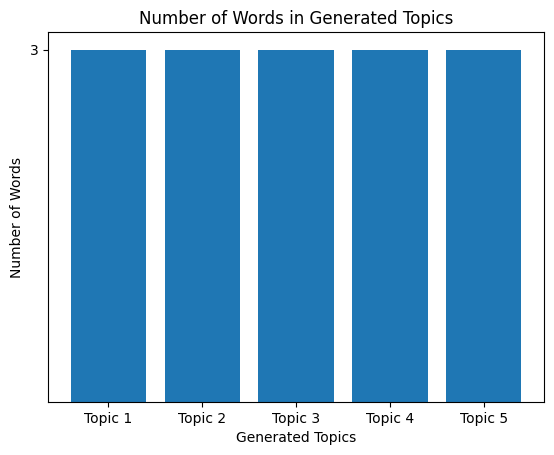

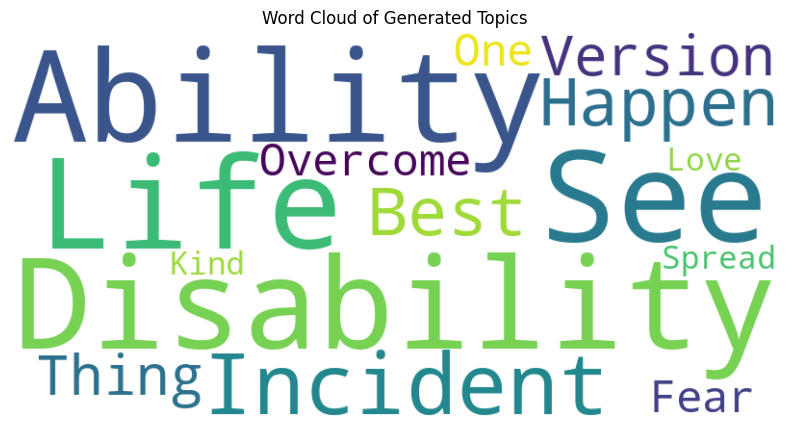

In [50]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Bar Chart Visualization
topic_lengths = [len(topic.split()) - 1 for topic in topics]  # Subtracting 1 to exclude the prompt length
topic_labels = [f"Topic {i}" for i in range(1, len(topics) + 1)]

plt.bar(topic_labels, topic_lengths)
plt.xlabel("Generated Topics")
plt.ylabel("Number of Words")
plt.title("Number of Words in Generated Topics")

# Set y-axis labels to display only whole numbers
plt.yticks(range(int(min(topic_lengths)), int(max(topic_lengths)) + 1))

plt.show()
print('\n')

# Word Cloud Visualization
all_topics_text = " ".join(topics)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_topics_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Generated Topics")
plt.show()

### **6.** **Model** **Evaluation**

In [51]:

# Model Evaluation
topic_lengths = [len(topic.split()) - 1 for topic in topics]  # Subtracting 1 to exclude the prompt length
average_topic_length = sum(topic_lengths) / len(topic_lengths)
print(f"Average topic length: {average_topic_length:.2f} words")


Average topic length: 3.00 words
